## Initial modeling experiments

In [3]:
# Setup
import pandas as pd
from sqlalchemy import create_engine, text
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


with open('database.yaml', 'r') as f:
    db_params = yaml.safe_load(f)

engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(
  host=db_params['host'],
  port=db_params['port'],
  dbname=db_params['db'],
  user=db_params['user'],
  password=db_params['pass']    
))

In [24]:
# Read in data
df = pd.read_sql('SELECT * FROM samples.labels', engine)
df.drop(['insert_time'], axis=1, inplace=True) # drop unnecessary columns
df.head()

,parcelid,initial_building_value,attic_sqft,bsmt_sqft,live_sqft,sqft_flr1,sqft_flr2,sqft_flrh,story_ht,year_built,...,full_bath,half_bath,fireplaces,garage_type,garage_capacity,finished_sq_ft,total_finish_area,first_floor_area,half_floor_area,finished_basement
0,0010001000500,NaN,0,1135,1176,1176,0,0,1.00,1928,...,1.0,0.0,1.0,Detached-001-Frame Construction,440,1176.0,1176.0,1176.0,0.0,0.0
1,0370001049000,NaN,0,924,1593,969,624,624,1.50,1925,...,2.0,0.0,1.0,Detached-001-Frame Construction,216,1593.0,1593.0,969.0,624.0,0.0
2,0370001049100,NaN,0,616,1188,634,554,554,1.75,1927,...,2.0,0.0,0.0,Detached-001-Frame Construction,400,634.0,1188.0,634.0,554.0,0.0
3,0370001049200,NaN,0,616,1190,636,554,0,1.75,1926,...,1.0,1.0,0.0,None,0,1190.0,1190.0,636.0,554.0,0.0
4,0370001049400,NaN,0,616,1479,986,0,493,1.50,1927,...,1.0,1.0,0.0,Detached-001-Frame Construction,216,986.0,1479.0,986.0,0.0,0.0


In [12]:
# How many labeled points?
df_labeled = df[(df['initial_building_value'].isna() == False)]
print(f"There are {len(df_labeled)} labeled observations")

There are 158 labeled observations


In [25]:
# For variables that have missing values, what is the % missing?
null_perc = df_labeled.isna().mean()
null_perc = null_perc[null_perc > 0]
null_perc

sale_price     0.088608
basement       0.012658
garage_type    0.512658
dtype: float64

### Distribution of outcome variable

Distribution of initial building value
count      158.000000
mean      3911.645570
std       4897.876293
min        340.000000
25%       2002.500000
50%       3025.000000
75%       4547.500000
max      56990.000000
Name: initial_building_value, dtype: float64


[Text(0.5, 1.0, 'Histogram of initial_building_value')]

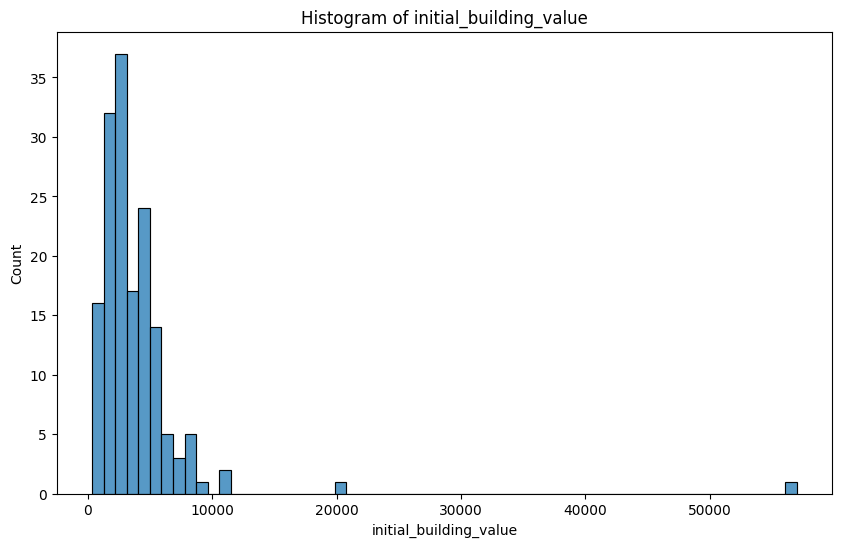

In [13]:
# Distribution of the outcome variable
print('Distribution of initial building value')
print(df_labeled['initial_building_value'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_labeled, x='initial_building_value').set(title='Histogram of initial_building_value')

In [15]:
## Correlations with other numeric variables
df_labeled.corrwith(df['initial_building_value'], numeric_only=True).sort_values()

year_built               -0.077327
total_sales_records      -0.075482
sale_price               -0.015791
number_of_parcels        -0.014130
sqft_flrh                 0.000966
appraisal_area            0.017435
prop_class_code           0.023256
attic_sqft                0.138502
story_ht                  0.193556
half_bath                 0.216908
sqft_flr2                 0.423983
half_floor_area           0.423983
total_rooms               0.445041
garage_capacity           0.448783
finished_basement         0.448833
full_bath                 0.453174
fireplaces                0.491224
live_sqft                 0.593170
total_finish_area         0.593170
first_floor_area          0.724287
sqft_flr1                 0.724287
bsmt_sqft                 0.740405
finished_sq_ft            0.782004
initial_building_value    1.000000
dtype: float64

In [26]:
# Descriptive linaer regression
reg = smf.ols('initial_building_value ~ year_built + finished_sq_ft + bsmt_sqft', df_labeled).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     initial_building_value   R-squared:                       0.711
Model:                                OLS   Adj. R-squared:                  0.705
Method:                     Least Squares   F-statistic:                     126.3
Date:                    Wed, 30 Nov 2022   Prob (F-statistic):           2.62e-41
Time:                            23:22:41   Log-Likelihood:                -1468.1
No. Observations:                     158   AIC:                             2944.
Df Residuals:                         154   BIC:                             2956.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -3.873e+04   2.64e+04     -1.467      0.144   -9.09e+04    1.34e+04
year_built        18.5834     13.824      1.344      0.181      -8.727      45.893
finished_sq_ft     2.4153      0.263      9.198      0.000       1.897       2.934
bsmt_sqft          4.4425      0.654      6.790      0.000       3.150       5.735
==============================================================================
Omnibus:                       83.264   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1627.385
Skew:                           1.360   Prob(JB):                         0.00
Kurtosis:                      18.485   Cond. No.                     3.23e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Mode

### Simple models

In [ ]:
# Do a train-test split